In [1]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

#

import matplotlib.pyplot as plt

from pandasgui import show

#

import warnings

In [2]:
warnings.filterwarnings( 'ignore' )

In [3]:
gmID_list = cfs.list_gmIDs()

In [4]:
topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [5]:
reference_red_route_best_pose_df = cfs.retrieve_gmID_topic( 'c0555ef0-f50f-11ee-8afa-cb629b0d53e6', '/apollo/sensor/gnss/best/pose' )

reference_green_route_best_pose_df = cfs.retrieve_gmID_topic( '5afabc8c-f035-11ee-b966-fb353e7798cd', '/apollo/sensor/gnss/best/pose' )

reference_blue_route_best_pose_df = cfs.retrieve_gmID_topic( '06cbdbc0-db4d-11ee-a158-97f8443fd730', '/apollo/sensor/gnss/best/pose' )

#

red_route_combined_df_list = []

green_route_combined_df_list = []

blue_route_combined_df_list = []

for gmID in gmID_list:

    #

    current_gmID_chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    current_gmID_best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    #

    current_gmID_chassis_df = current_gmID_chassis_df.sort_values( 'time' )

    current_gmID_best_pose_df = current_gmID_best_pose_df.sort_values( 'time' )

    #

    cfs.BinaryDrivingMode( current_gmID_chassis_df )

    cfs.TernaryDrivingModeTransition( current_gmID_chassis_df )

    cfs.NormalizedTime( current_gmID_chassis_df )

    cfs.DeltaTime( current_gmID_chassis_df )

    #

    cfs.LatLonTotalStdDev( current_gmID_best_pose_df )

    cfs.NormalizedTime( current_gmID_best_pose_df )

    cfs.DeltaTime( current_gmID_best_pose_df )

    #

    route = cfs.give_route( gmID )

    if ( route == 'Red' ):

        cfs.ProgressAlongRoute( current_gmID_best_pose_df, reference_red_route_best_pose_df )

    elif ( route == 'Green' ):

        cfs.ProgressAlongRoute( current_gmID_best_pose_df, reference_green_route_best_pose_df )

    else:

        cfs.ProgressAlongRoute( current_gmID_best_pose_df, reference_blue_route_best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( current_gmID_chassis_df, current_gmID_best_pose_df )

    #

    current_gmID_combined_df = pd.merge( current_gmID_chassis_df, current_gmID_best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    if ( route == 'Red' ):

        red_route_combined_df_list.append( current_gmID_combined_df )

    elif ( route == 'Green' ):

        green_route_combined_df_list.append( current_gmID_combined_df )

    else:

        blue_route_combined_df_list.append( current_gmID_combined_df )

In [6]:
red_route_combined_df_all = pd.concat( red_route_combined_df_list )

green_route_combined_df_all = pd.concat( green_route_combined_df_list )

blue_route_combined_df_all = pd.concat( blue_route_combined_df_list )

In [27]:
all_route_df = pd.concat( [ red_route_combined_df_all, green_route_combined_df_all, blue_route_combined_df_all ] )

In [7]:
red_route_combined_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5178034 entries, 0 to 22207
Data columns (total 29 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   brakePercentage               float64
 1   groupMetadataID_x             object 
 2   drivingMode                   object 
 3   speedMps                      float64
 4   time_x                        int64  
 5   throttlePercentage            float64
 6   steeringPercentage            float64
 7   signal.turnSignal             object 
 8   BinaryDrivingMode             int64  
 9   TernaryDrivingModeTransition  int64  
 10  NormalizedTime_x              int64  
 11  DeltaTime_x                   int64  
 12  ChassisBestPoseMatchedTime    int64  
 13  heightMsl                     float64
 14  groupMetadataID_y             object 
 15  latitudeStdDev                float64
 16  longitude                     float64
 17  solType                       object 
 18  extendedSolutionStatus       

In [8]:
quantitative_variables = [ 'brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage', 'numSatsInSolution', \
                           'LatLonTotalStdDev', 'ProgressAlongRoute', 'heightStdDev' ]

qualitative_variables = [ 'signal.turnSignal', 'extendedSolutionStatus', 'BinaryDrivingMode', 'TernaryDrivingModeTransition' ]

variables = quantitative_variables + qualitative_variables

In [9]:
combinations = []

for variable_x in variables:

    for variable_y in variables:

        combination = { variable_x, variable_y }

        if combination not in combinations:

            combinations.append( combination )

In [10]:
len( combinations )

78

In [11]:
for combination in combinations:

    if 'BinaryDrivingMode' in combination:

        print( combination )

{'brakePercentage', 'BinaryDrivingMode'}
{'speedMps', 'BinaryDrivingMode'}
{'BinaryDrivingMode', 'throttlePercentage'}
{'steeringPercentage', 'BinaryDrivingMode'}
{'BinaryDrivingMode', 'numSatsInSolution'}
{'LatLonTotalStdDev', 'BinaryDrivingMode'}
{'BinaryDrivingMode', 'ProgressAlongRoute'}
{'BinaryDrivingMode', 'heightStdDev'}
{'signal.turnSignal', 'BinaryDrivingMode'}
{'BinaryDrivingMode', 'extendedSolutionStatus'}
{'BinaryDrivingMode'}
{'TernaryDrivingModeTransition', 'BinaryDrivingMode'}


In [12]:
# BinaryDrivingMode/TernaryDrivingModeTransition, extendedSolutionStatus Plots

In [38]:
extendedSolutionStatus_unqiuelist = all_route_df[ 'extendedSolutionStatus' ].value_counts().index.tolist()

base_dict = {}

for key in extendedSolutionStatus_unqiuelist:

    base_dict[ key ] = 0

In [39]:
all_routes_extendedSolutionStatus_values = all_route_df[ 'extendedSolutionStatus' ].value_counts().index.tolist()

all_routes_extendedSolutionStatus_counts = list( all_route_df[ 'extendedSolutionStatus' ].value_counts() )

all_routes_extendedSolutionStatus_valuecounts = base_dict.copy()

for value, count in zip( all_routes_extendedSolutionStatus_values, all_routes_extendedSolutionStatus_counts ):

    all_routes_extendedSolutionStatus_valuecounts[ value ] = count

In [40]:
all_routes_manual_extendedSolutionStatus_values = all_route_df[ all_route_df[ 'BinaryDrivingMode' ] == 0 ] \
                                                              [ 'extendedSolutionStatus' ].value_counts().index.tolist()

all_routes_manual_extendedSolutionStatus_counts = list( all_route_df[ all_route_df[ 'BinaryDrivingMode' ] == 0 ] \
                                                                    [ 'extendedSolutionStatus' ].value_counts() )

all_routes_manual_extendedSolutionStatus_valuecounts = base_dict.copy()

for value, count in zip( all_routes_manual_extendedSolutionStatus_values, all_routes_manual_extendedSolutionStatus_counts ):

    all_routes_manual_extendedSolutionStatus_valuecounts[ value ] = count

In [43]:
all_routes_auto_extendedSolutionStatus_values = all_route_df[ all_route_df[ 'BinaryDrivingMode' ] == 1 ] \
                                                              [ 'extendedSolutionStatus' ].value_counts().index.tolist()

all_routes_auto_extendedSolutionStatus_counts = list( all_route_df[ all_route_df[ 'BinaryDrivingMode' ] == 1 ] \
                                                                    [ 'extendedSolutionStatus' ].value_counts() )

all_routes_auto_extendedSolutionStatus_valuecounts = base_dict.copy()

for value, count in zip( all_routes_auto_extendedSolutionStatus_values, all_routes_auto_extendedSolutionStatus_counts ):

    all_routes_auto_extendedSolutionStatus_valuecounts[ value ] = count

In [45]:
all_routes_disengagement_extendedSolutionStatus_values = all_route_df[ all_route_df[ 'TernaryDrivingModeTransition' ] == -1 ] \
                                                              [ 'extendedSolutionStatus' ].value_counts().index.tolist()

all_routes_disengagement_extendedSolutionStatus_counts = list( all_route_df[ all_route_df[ 'TernaryDrivingModeTransition' ] == -1 ] \
                                                                    [ 'extendedSolutionStatus' ].value_counts() )

all_routes_disengagement_extendedSolutionStatus_valuecounts = base_dict.copy()

for value, count in zip( all_routes_disengagement_extendedSolutionStatus_values, all_routes_disengagement_extendedSolutionStatus_counts ):

    all_routes_disengagement_extendedSolutionStatus_valuecounts[ value ] = count

In [47]:
all_routes_reengagement_extendedSolutionStatus_values = all_route_df[ all_route_df[ 'TernaryDrivingModeTransition' ] == 1 ] \
                                                              [ 'extendedSolutionStatus' ].value_counts().index.tolist()

all_routes_reengagement_extendedSolutionStatus_counts = list( all_route_df[ all_route_df[ 'TernaryDrivingModeTransition' ] == 1 ] \
                                                                    [ 'extendedSolutionStatus' ].value_counts() )

all_routes_reengagement_extendedSolutionStatus_valuecounts = base_dict.copy()

for value, count in zip( all_routes_reengagement_extendedSolutionStatus_values, all_routes_reengagement_extendedSolutionStatus_counts ):

    all_routes_reengagement_extendedSolutionStatus_valuecounts[ value ] = count

In [49]:
all_routes_noengagement_extendedSolutionStatus_values = all_route_df[ all_route_df[ 'TernaryDrivingModeTransition' ] == 0 ] \
                                                              [ 'extendedSolutionStatus' ].value_counts().index.tolist()

all_routes_noengagement_extendedSolutionStatus_counts = list( all_route_df[ all_route_df[ 'TernaryDrivingModeTransition' ] == 0 ] \
                                                                    [ 'extendedSolutionStatus' ].value_counts() )

all_routes_noengagement_extendedSolutionStatus_valuecounts = base_dict.copy()

for value, count in zip( all_routes_noengagement_extendedSolutionStatus_values, all_routes_noengagement_extendedSolutionStatus_counts ):

    all_routes_noengagement_extendedSolutionStatus_valuecounts[ value ] = count

In [50]:
print( all_routes_extendedSolutionStatus_valuecounts )

print( all_routes_manual_extendedSolutionStatus_valuecounts )

print( all_routes_auto_extendedSolutionStatus_valuecounts )

print( all_routes_disengagement_extendedSolutionStatus_valuecounts )

print( all_routes_reengagement_extendedSolutionStatus_valuecounts )

print( all_routes_noengagement_extendedSolutionStatus_valuecounts )

{33: 10830866, 32: 2657204, 8: 467470, 136: 415370, 6: 127506, 0: 73459, 134: 31286, 2: 3652, 130: 302}
{33: 4157566, 32: 1096390, 8: 155672, 136: 163411, 6: 122578, 0: 30319, 134: 29634, 2: 2057, 130: 150}
{33: 6673300, 32: 1560814, 8: 311798, 136: 251959, 6: 4928, 0: 43140, 134: 1652, 2: 1595, 130: 152}
{33: 1507, 32: 449, 8: 109, 136: 129, 6: 7, 0: 14, 134: 0, 2: 2, 130: 0}
{33: 1638, 32: 416, 8: 73, 136: 63, 6: 4, 0: 18, 134: 3, 2: 2, 130: 0}
{33: 10827721, 32: 2656339, 8: 467288, 136: 415178, 6: 127495, 0: 73427, 134: 31283, 2: 3648, 130: 302}


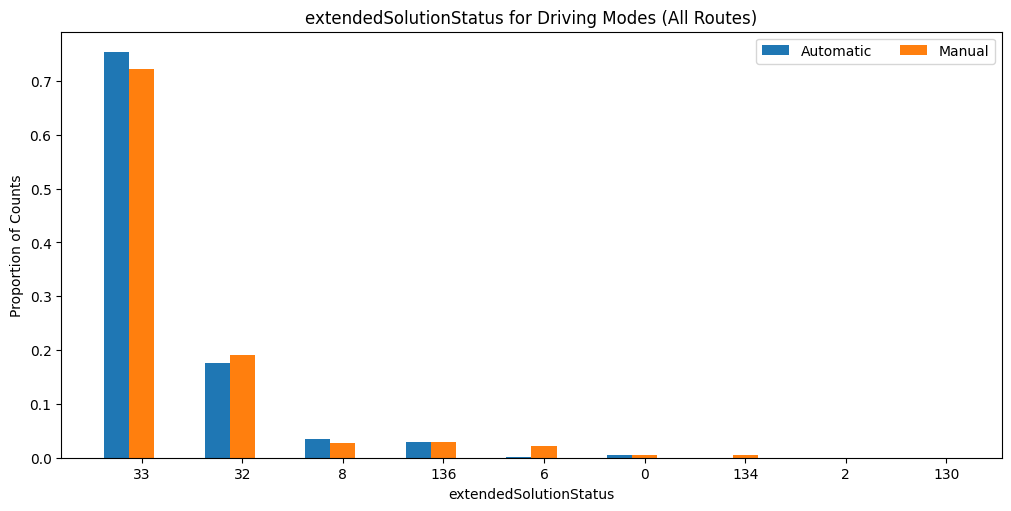

In [72]:
bar_labels = [ str( x ) for x in all_routes_extendedSolutionStatus_valuecounts.keys() ]

subbar1_counts = np.array( [ x for x in all_routes_auto_extendedSolutionStatus_valuecounts.values() ] )

subbar2_counts = np.array( [ x for x in all_routes_manual_extendedSolutionStatus_valuecounts.values() ] )

subbar_labels_counts = {

    'Automatic': subbar1_counts / np.sum( subbar1_counts ),
    
    'Manual': subbar2_counts / np.sum( subbar2_counts )
    
}

x = np.arange( len( bar_labels ) )  # the label locations

width = 0.25  # the width of the bars

multiplier = 0

fig, ax = plt.subplots( layout = 'constrained' )

fig.set_size_inches( 10, 5 )

for subbar_label, counts in subbar_labels_counts.items():
    
    offset = width * multiplier
    
    rects = ax.bar( x + offset, counts, width, label = subbar_label )
    
    # ax.bar_label( rects, padding = 3 )
    
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xlabel( 'extendedSolutionStatus' )

ax.set_ylabel( 'Proportion of Counts' )

ax.set_title( 'extendedSolutionStatus for Driving Modes (All Routes)' )

ax.set_xticks( x + width, bar_labels )

ax.legend( loc = 'upper right', ncols = 2 )

plt.show()

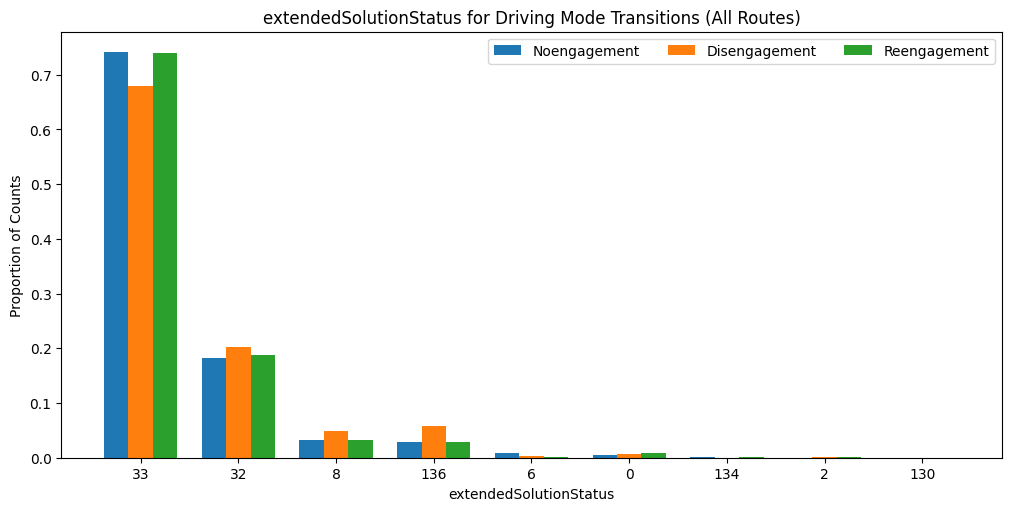

In [74]:
bar_labels = [ str( x ) for x in all_routes_extendedSolutionStatus_valuecounts.keys() ]

subbar1_counts = np.array( [ x for x in all_routes_noengagement_extendedSolutionStatus_valuecounts.values() ] )

subbar2_counts = np.array( [ x for x in all_routes_disengagement_extendedSolutionStatus_valuecounts.values() ] )

subbar3_counts = np.array( [ x for x in all_routes_reengagement_extendedSolutionStatus_valuecounts.values() ] )

subbar_labels_counts = {

    'Noengagement': subbar1_counts / np.sum( subbar1_counts ),
    
    'Disengagement': subbar2_counts / np.sum( subbar2_counts ),

    'Reengagement': subbar3_counts / np.sum( subbar3_counts )
    
}

x = np.arange( len( bar_labels ) )  # the label locations

width = 0.25  # the width of the bars

multiplier = 0

fig, ax = plt.subplots( layout = 'constrained' )

fig.set_size_inches( 10, 5 )

for subbar_label, counts in subbar_labels_counts.items():
    
    offset = width * multiplier
    
    rects = ax.bar( x + offset, counts, width, label = subbar_label )
    
    # ax.bar_label( rects, padding = 3 )
    
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xlabel( 'extendedSolutionStatus' )

ax.set_ylabel( 'Proportion of Counts' )

ax.set_title( 'extendedSolutionStatus for Driving Mode Transitions (All Routes)' )

ax.set_xticks( x + width, bar_labels )

ax.legend( loc = 'upper right', ncols = 3 )

plt.show()